In [ ]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

# --- ШАГ 2: ПОДКЛЮЧЕНИЕ К БД ---
db_user = 'postgres'
db_password = 'glavvrach228007' # Твой пароль
db_host = 'localhost'
db_port = '5432'
db_name = 'social_economics'
table_name = 'rosstat_data'

try:
    engine = create_engine(
        f'postgresql+psycopg://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}',
        connect_args={'options': '-c client_encoding=utf8'}
    )
    print("✅ Соединение с базой данных PostgreSQL успешно установлено!")
except Exception as e:
    print(f"❌ Ошибка подключения к базе данных: {e}")


# --- ШАГ 3: ЗАГРУЗКА ДАННЫХ ЧАСТЯМИ (CHUNKING) ---
sql_query_all_data = f"SELECT * FROM {table_name};"
chunk_size = 100000  # Читаем по 100,000 строк за раз
df_chunks = []      # Список для хранения "кусков"

print(f"\nНачинаем загрузку данных из таблицы '{table_name}' частями...")

try:
    # pd.read_sql с параметром chunksize возвращает "итератор",
    # который мы можем перебирать в цикле
    for chunk in pd.read_sql(sql_query_all_data, engine, chunksize=chunk_size):
        df_chunks.append(chunk)
        print(f"  - Загружен чанк размером {len(chunk)} строк")

    # Склеиваем все загруженные части в один большой DataFrame
    df = pd.concat(df_chunks, ignore_index=True)

    print(f"\n✅ Успех! Все {df.shape[0]} строк загружены из базы данных.")
    print("\nПервые 5 строк загруженных данных:")
    display(df.head())

except Exception as e:
    print(f"❌ Ошибка при выполнении SQL-запроса: {e}")

✅ Соединение с базой данных PostgreSQL успешно установлено!

Начинаем загрузку данных из таблицы 'rosstat_data' частями...
  - Загружен чанк размером 100000 строк
  - Загружен чанк размером 100000 строк
  - Загружен чанк размером 100000 строк
  - Загружен чанк размером 100000 строк
  - Загружен чанк размером 100000 строк
  - Загружен чанк размером 100000 строк
  - Загружен чанк размером 100000 строк
  - Загружен чанк размером 100000 строк
  - Загружен чанк размером 100000 строк
  - Загружен чанк размером 100000 строк
  - Загружен чанк размером 100000 строк
  - Загружен чанк размером 100000 строк
  - Загружен чанк размером 100000 строк
  - Загружен чанк размером 100000 строк
  - Загружен чанк размером 41416 строк

✅ Успех! Все 1441416 строк загружены из базы данных.

Первые 5 строк загруженных данных:


,section,indicator_code,indicator_name,subsection,object_name,object_level,object_oktmo,object_okato,year,indicator_value,indicator_unit,comment,source
0,Население,Y4170101000000,Численность населения,CD,Российская Федерация,страна,0,0,2000,146303.6,"оценка на конец года, тысяч человек",CD,Регионы России. Социально-экономические показа...
1,Население,Y4170101000000,Численность населения,CD,Российская Федерация,страна,0,0,2001,145649.3,"оценка на конец года, тысяч человек",CD,Регионы России. Социально-экономические показа...
2,Население,Y4170101000000,Численность населения,CD,Российская Федерация,страна,0,0,2002,144963.6,"оценка на конец года, тысяч человек",CD,Регионы России. Социально-экономические показа...
3,Население,Y4170101000000,Численность населения,CD,Российская Федерация,страна,0,0,2003,144333.6,"оценка на конец года, тысяч человек",CD,Регионы России. Социально-экономические показа...
4,Население,Y4170101000000,Численность населения,CD,Российская Федерация,страна,0,0,2004,143801.0,"оценка на конец года, тысяч человек",CD,Регионы России. Социально-экономические показа...


In [2]:
# --- ШАГ 4: ФИЛЬТРАЦИЯ, ОЧИСТКА И ТРАНСФОРМАЦИЯ ---

# Наш финальный, проверенный список показателей
final_indicator_list = [
    'Среднедушевые денежные доходы населения',
    'Численность населения с денежными доходами ниже границы бедности/величины прожиточного минимума',
    'Реальные денежные доходы: Реальная начисленная заработная плата работников организаций',
    'Ожидаемая продолжительность жизни при рождении',
    'Численность врачей всех специальностей: На 10 000 человек населения',
    'Средние цены на вторичном рынке жилья',
    'Уровень безработицы'
]

print("--- Начинаем фильтрацию и очистку данных в Pandas ---")

# 1. Фильтруем по названию показателя
filtered_df = df[df['indicator_name'].isin(final_indicator_list)].copy()

# 2. Фильтруем по уровню 'регион'
filtered_df = filtered_df[filtered_df['object_level'] == 'регион']

# 3. Фильтруем по году (>= 2015)
filtered_df = filtered_df[filtered_df['year'] >= 2015]

print(f"✅ После фильтрации осталось {filtered_df.shape[0]} строк.")

# 4. Очистка "мусорных" значений
values_to_replace = [-99999999, -77777777]
filtered_df['indicator_value'] = filtered_df['indicator_value'].replace(values_to_replace, np.nan)
print("✅ 'Мусорные' значения заменены на NaN.")

# 5. Трансформация в "широкий" формат
wide_df = filtered_df.pivot_table(
    index=['object_name', 'year'],
    columns='indicator_name',
    values='indicator_value'
).reset_index()
wide_df.columns.name = None
print("✅ Таблица успешно трансформирована в 'широкий' формат.")

# 6. Упрощаем названия столбцов
new_column_names = {
    'object_name': 'region', 'year': 'year',
    'Ожидаемая продолжительность жизни при рождении': 'life_expectancy',
    'Реальные денежные доходы: Реальная начисленная заработная плата работников организаций': 'real_wage_growth_pct',
    'Среднедушевые денежные доходы населения': 'avg_income',
    'Средние цены на вторичном рынке жилья': 'housing_price_sqm',
    'Уровень безработицы': 'unemployment_rate_pct',
    'Численность населения с денежными доходами ниже границы бедности/величины прожиточного минимума': 'poverty_rate_pct',
    'Численность врачей всех специальностей: На 10 000 человек населения': 'doctors_per_10k'
}
wide_df = wide_df.rename(columns=new_column_names)
print("✅ Названия столбцов упрощены.")

print("\n--- Финальная таблица 'wide_df' готова к анализу ---")
display(wide_df.head())
wide_df.info()

--- Начинаем фильтрацию и очистку данных в Pandas ---
✅ После фильтрации осталось 4263 строк.
✅ 'Мусорные' значения заменены на NaN.
✅ Таблица успешно трансформирована в 'широкий' формат.
✅ Названия столбцов упрощены.

--- Финальная таблица 'wide_df' готова к анализу ---


,region,year,real_wage_growth_pct,avg_income,housing_price_sqm,unemployment_rate_pct,doctors_per_10k,poverty_rate_pct
0,Алтайский край,2015,90.000000,21276.512870,43618.0,NaN,43.9,17.6
1,Алтайский край,2016,98.400000,21778.665790,41120.0,NaN,44.3,17.4
2,Алтайский край,2017,103.551438,22788.442501,41293.0,NaN,44.7,17.0
3,Алтайский край,2018,109.300052,23665.910409,44219.0,NaN,44.3,16.8
4,Алтайский край,2019,104.872918,24935.228698,47754.0,5.801665,44.4,16.9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   region                 783 non-null    object 
 1   year                   783 non-null    int64  
 2   real_wage_growth_pct   781 non-null    float64
 3   avg_income             783 non-null    float64
 4   housing_price_sqm      772 non-null    float64
 5   unemployment_rate_pct  348 non-null    float64
 6   doctors_per_10k        783 non-null    float64
 7   poverty_rate_pct       783 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 49.1+ KB


--- 1. Гистограммы распределения ---


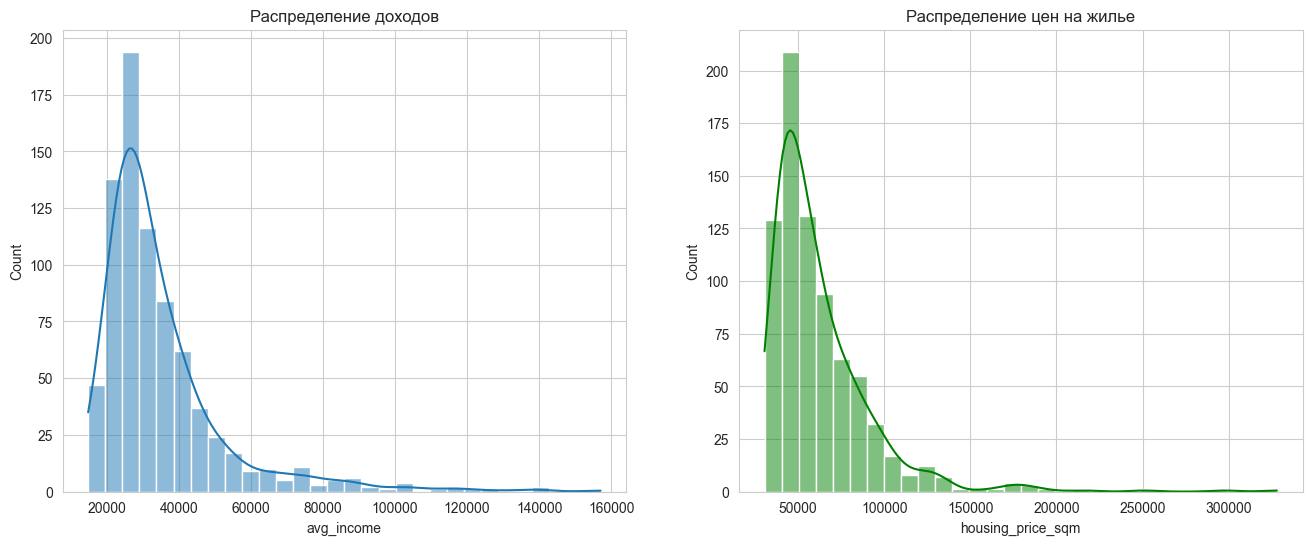


--- 2. Динамика среднего дохода по годам ---


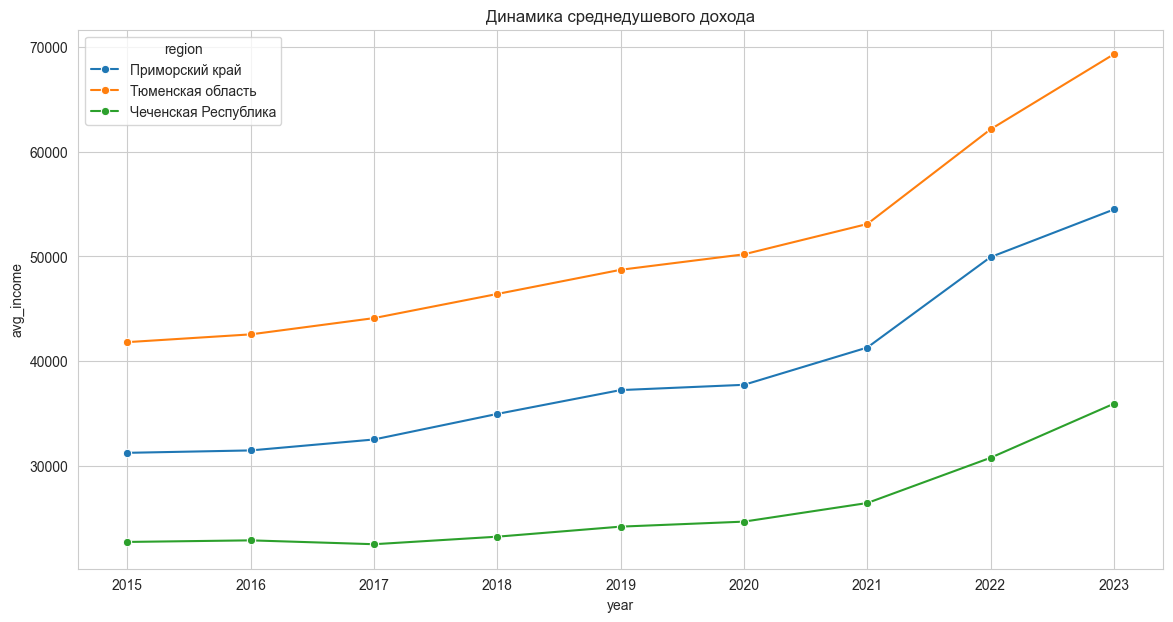


--- 3. Матрица корреляций ---


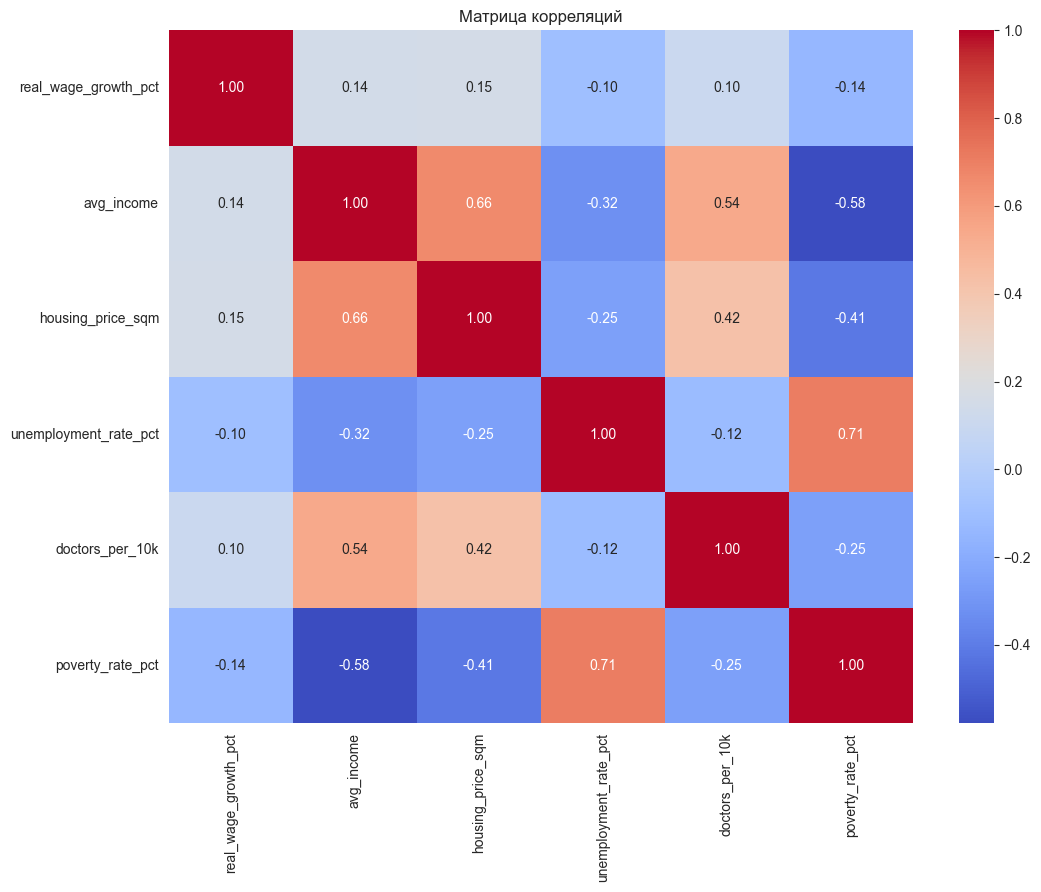

In [3]:
# --- 1. АНАЛИЗ РАСПРЕДЕЛЕНИЙ ---
print("--- 1. Гистограммы распределения ---")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(wide_df['avg_income'], kde=True, ax=axes[0], bins=30).set_title('Распределение доходов')
sns.histplot(wide_df['housing_price_sqm'], kde=True, ax=axes[1], color='green', bins=30).set_title('Распределение цен на жилье')
plt.show()

# --- 2. АНАЛИЗ ДИНАМИКИ ---
print("\n--- 2. Динамика среднего дохода по годам ---")
regions_to_plot = ['г. Москва', 'Чеченская Республика', 'Тюменская область', 'Приморский край']
df_subset = wide_df[wide_df['region'].isin(regions_to_plot)]
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_subset, x='year', y='avg_income', hue='region', marker='o').set_title('Динамика среднедушевого дохода')
plt.show()

# --- 3. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ ---
print("\n--- 3. Матрица корреляций ---")
plt.figure(figsize=(12, 9))
numeric_cols = wide_df.select_dtypes(include=np.number).drop(columns=['year'])
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f').set_title('Матрица корреляций')
plt.show()

In [4]:
# Убедимся, что у нас есть 'engine' для подключения к БД
if 'engine' in locals():
    print("--- Ищем показатели, связанные с миграцией, в базе данных ---")

    # SQL-запрос для получения ВСЕХ уникальных названий показателей из нашей таблицы
    # Это гораздо быстрее, чем загружать 1.4 млн строк
    sql_query_names = "SELECT DISTINCT indicator_name FROM rosstat_data;"

    # Выполняем запрос и получаем DataFrame с одним столбцом
    all_indicators_df = pd.read_sql(sql_query_names, engine)

    # Преобразуем столбец в список для удобного поиска
    all_indicators = all_indicators_df['indicator_name'].tolist()

    print(f"Найдено {len(all_indicators)} уникальных показателей.")

    # Ключевые слова для поиска
    keywords = ['миграц', 'прибывш', 'выбывш']

    print("\n--- Результаты поиска: ---")
    found_count = 0
    for indicator in all_indicators:
        # Проверяем, содержит ли название одно из ключевых слов
        if any(keyword in indicator.lower() for keyword in keywords):
            print(f"  - {indicator}")
            found_count += 1

    if found_count == 0:
        print("Не найдено ни одного показателя по миграции. Попробуйте другие ключевые слова.")

else:
    print("❌ Переменная 'engine' для подключения к БД не найдена. Запустите первую ячейку с подключением.")

--- Ищем показатели, связанные с миграцией, в базе данных ---
Найдено 823 уникальных показателей.

--- Результаты поиска: ---
  - Коэффициенты миграционного прироста на 10 000 человек населения
  - Межрегиональная трудовая миграция в Российской Федерации
  - Распределение числа выбывших по направлениям передвижения: В другие регионы России
  - Распределение числа выбывших по направлениям передвижения: В пределах региона
  - Распределение числа выбывших по направлениям передвижения: За пределы России
  - Распределение числа прибывших по направлениям передвижения: В пределах региона
  - Распределение числа прибывших по направлениям передвижения: Из-за пределов России
  - Распределение числа прибывших по направлениям передвижения: Из других регионов


Выполняем SQL-запрос для получения данных о миграции...
✅ Данные по миграции успешно загружены.

--- Рейтинг регионов по миграционному приросту за 2023 год ---


C:\Users\user\AppData\Local\Temp\ipykernel_14116\3406419216.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_regions, x='migration_rate_per_10k', y='object_name', ax=axes[0], palette='Greens_r')
C:\Users\user\AppData\Local\Temp\ipykernel_14116\3406419216.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom_regions, x='migration_rate_per_10k', y='object_name', ax=axes[1], palette='Reds_r')


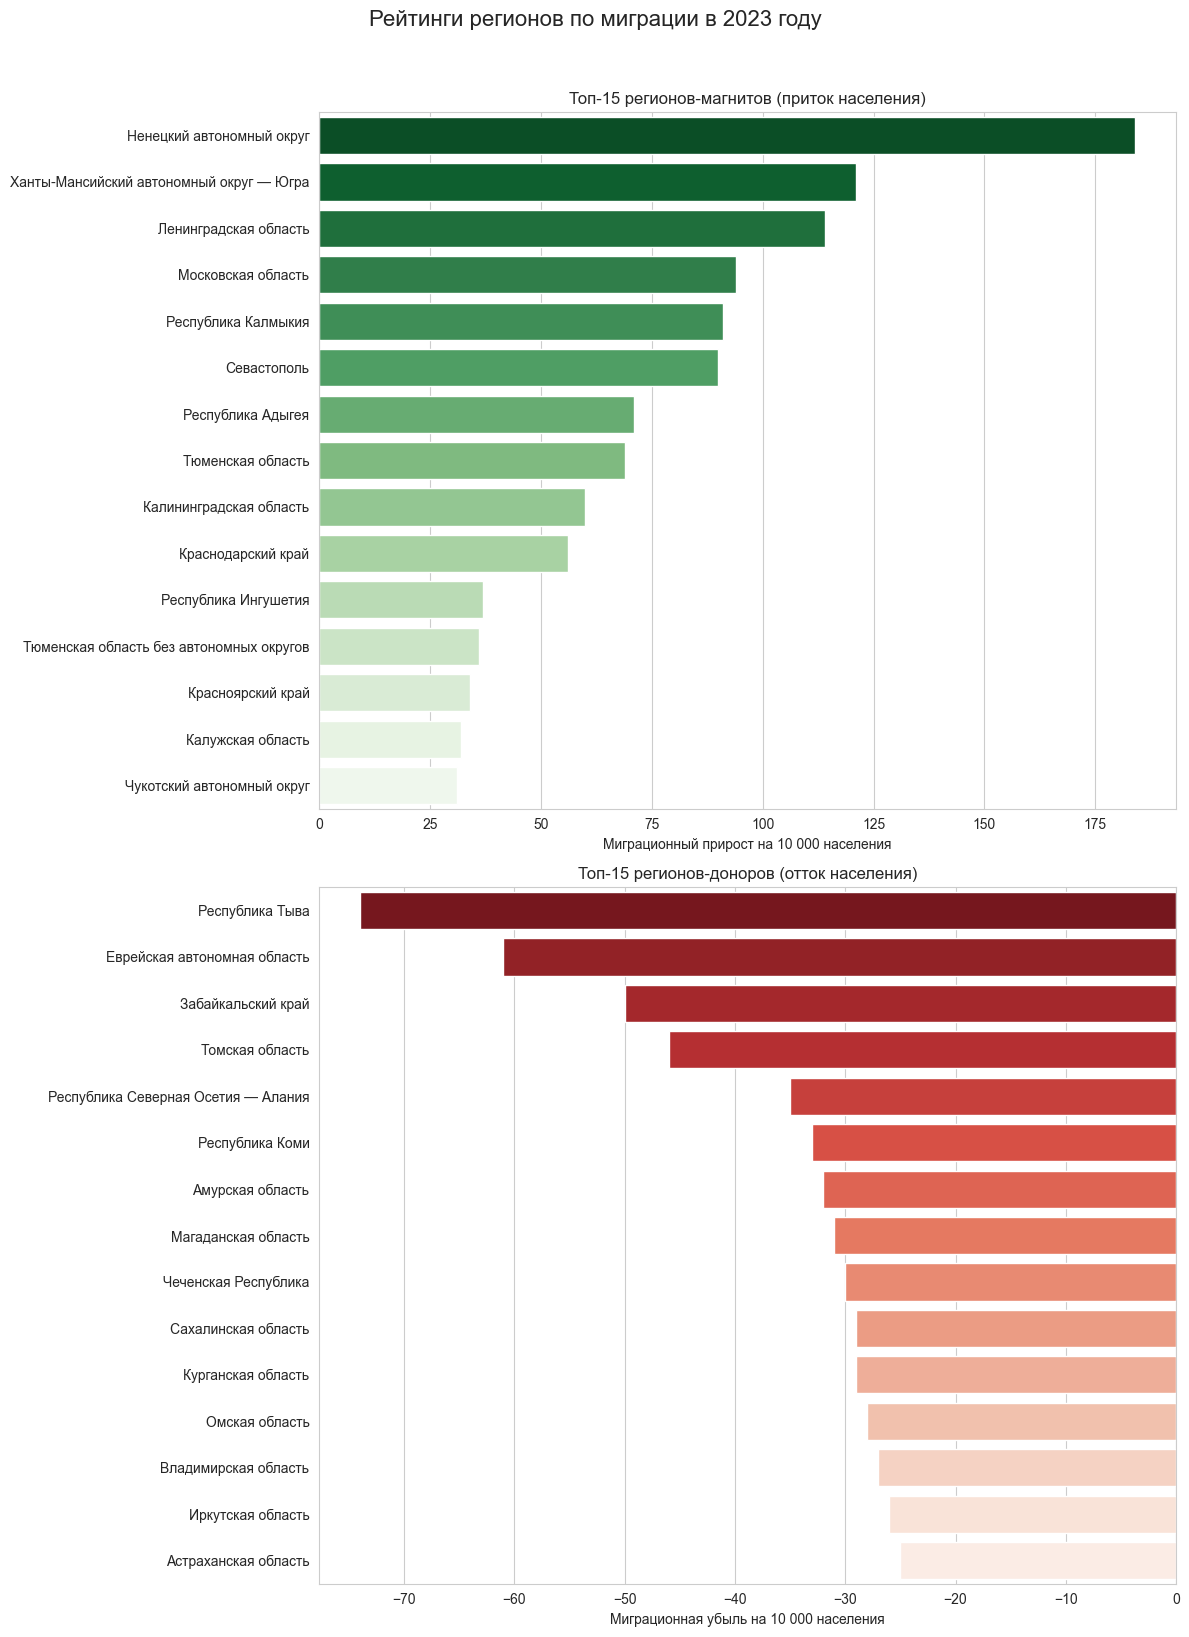

In [5]:
# --- ШАГ 2: ИЗВЛЕЧЕНИЕ ДАННЫХ ПО МИГРАЦИИ ---

# Мы используем точное название, которое только что нашли
MIGRATION_INDICATOR_NAME = 'Коэффициенты миграционного прироста на 10 000 человек населения'

if 'engine' in locals():
    # Создаем SQL-запрос
    sql_query_migration = f"""
    SELECT
        object_name,
        year,
        indicator_value
    FROM
        rosstat_data
    WHERE
        indicator_name = '{MIGRATION_INDICATOR_NAME}'
        AND object_level = 'регион';
    """

    print("Выполняем SQL-запрос для получения данных о миграции...")
    migration_df = pd.read_sql(sql_query_migration, engine)
    migration_df = migration_df.rename(columns={'indicator_value': 'migration_rate_per_10k'})

    print("✅ Данные по миграции успешно загружены.")

    # --- ШАГ 3: ВИЗУАЛИЗАЦИЯ ---

    # Находим последний год
    last_year = migration_df['year'].max()
    print(f"\n--- Рейтинг регионов по миграционному приросту за {last_year} год ---")

    df_last_year_migration = migration_df[migration_df['year'] == last_year].dropna()

    # Топ-15 по ПРИТОКУ
    top_regions = df_last_year_migration.sort_values('migration_rate_per_10k', ascending=False).head(15)

    # Топ-15 по ОТТОКУ
    bottom_regions = df_last_year_migration.sort_values('migration_rate_per_10k', ascending=True).head(15)

    # Создаем фигуру для графиков
    fig, axes = plt.subplots(2, 1, figsize=(12, 16))
    fig.suptitle(f'Рейтинги регионов по миграции в {last_year} году', fontsize=16, y=1.02)

    # График притока
    sns.barplot(data=top_regions, x='migration_rate_per_10k', y='object_name', ax=axes[0], palette='Greens_r')
    axes[0].set_title(f'Топ-15 регионов-магнитов (приток населения)')
    axes[0].set_xlabel('Миграционный прирост на 10 000 населения')
    axes[0].set_ylabel('')

    # График оттока
    sns.barplot(data=bottom_regions, x='migration_rate_per_10k', y='object_name', ax=axes[1], palette='Reds_r')
    axes[1].set_title(f'Топ-15 регионов-доноров (отток населения)')
    axes[1].set_xlabel('Миграционная убыль на 10 000 населения')
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

else:
    print("❌ Переменная 'engine' для подключения к БД не найдена. Перезапустите и выполните все ячейки (Restart & Run All).")

--- Полный рейтинг всех регионов по миграционному приросту за 2023 год ---


C:\Users\user\AppData\Local\Temp\ipykernel_14116\3803351274.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


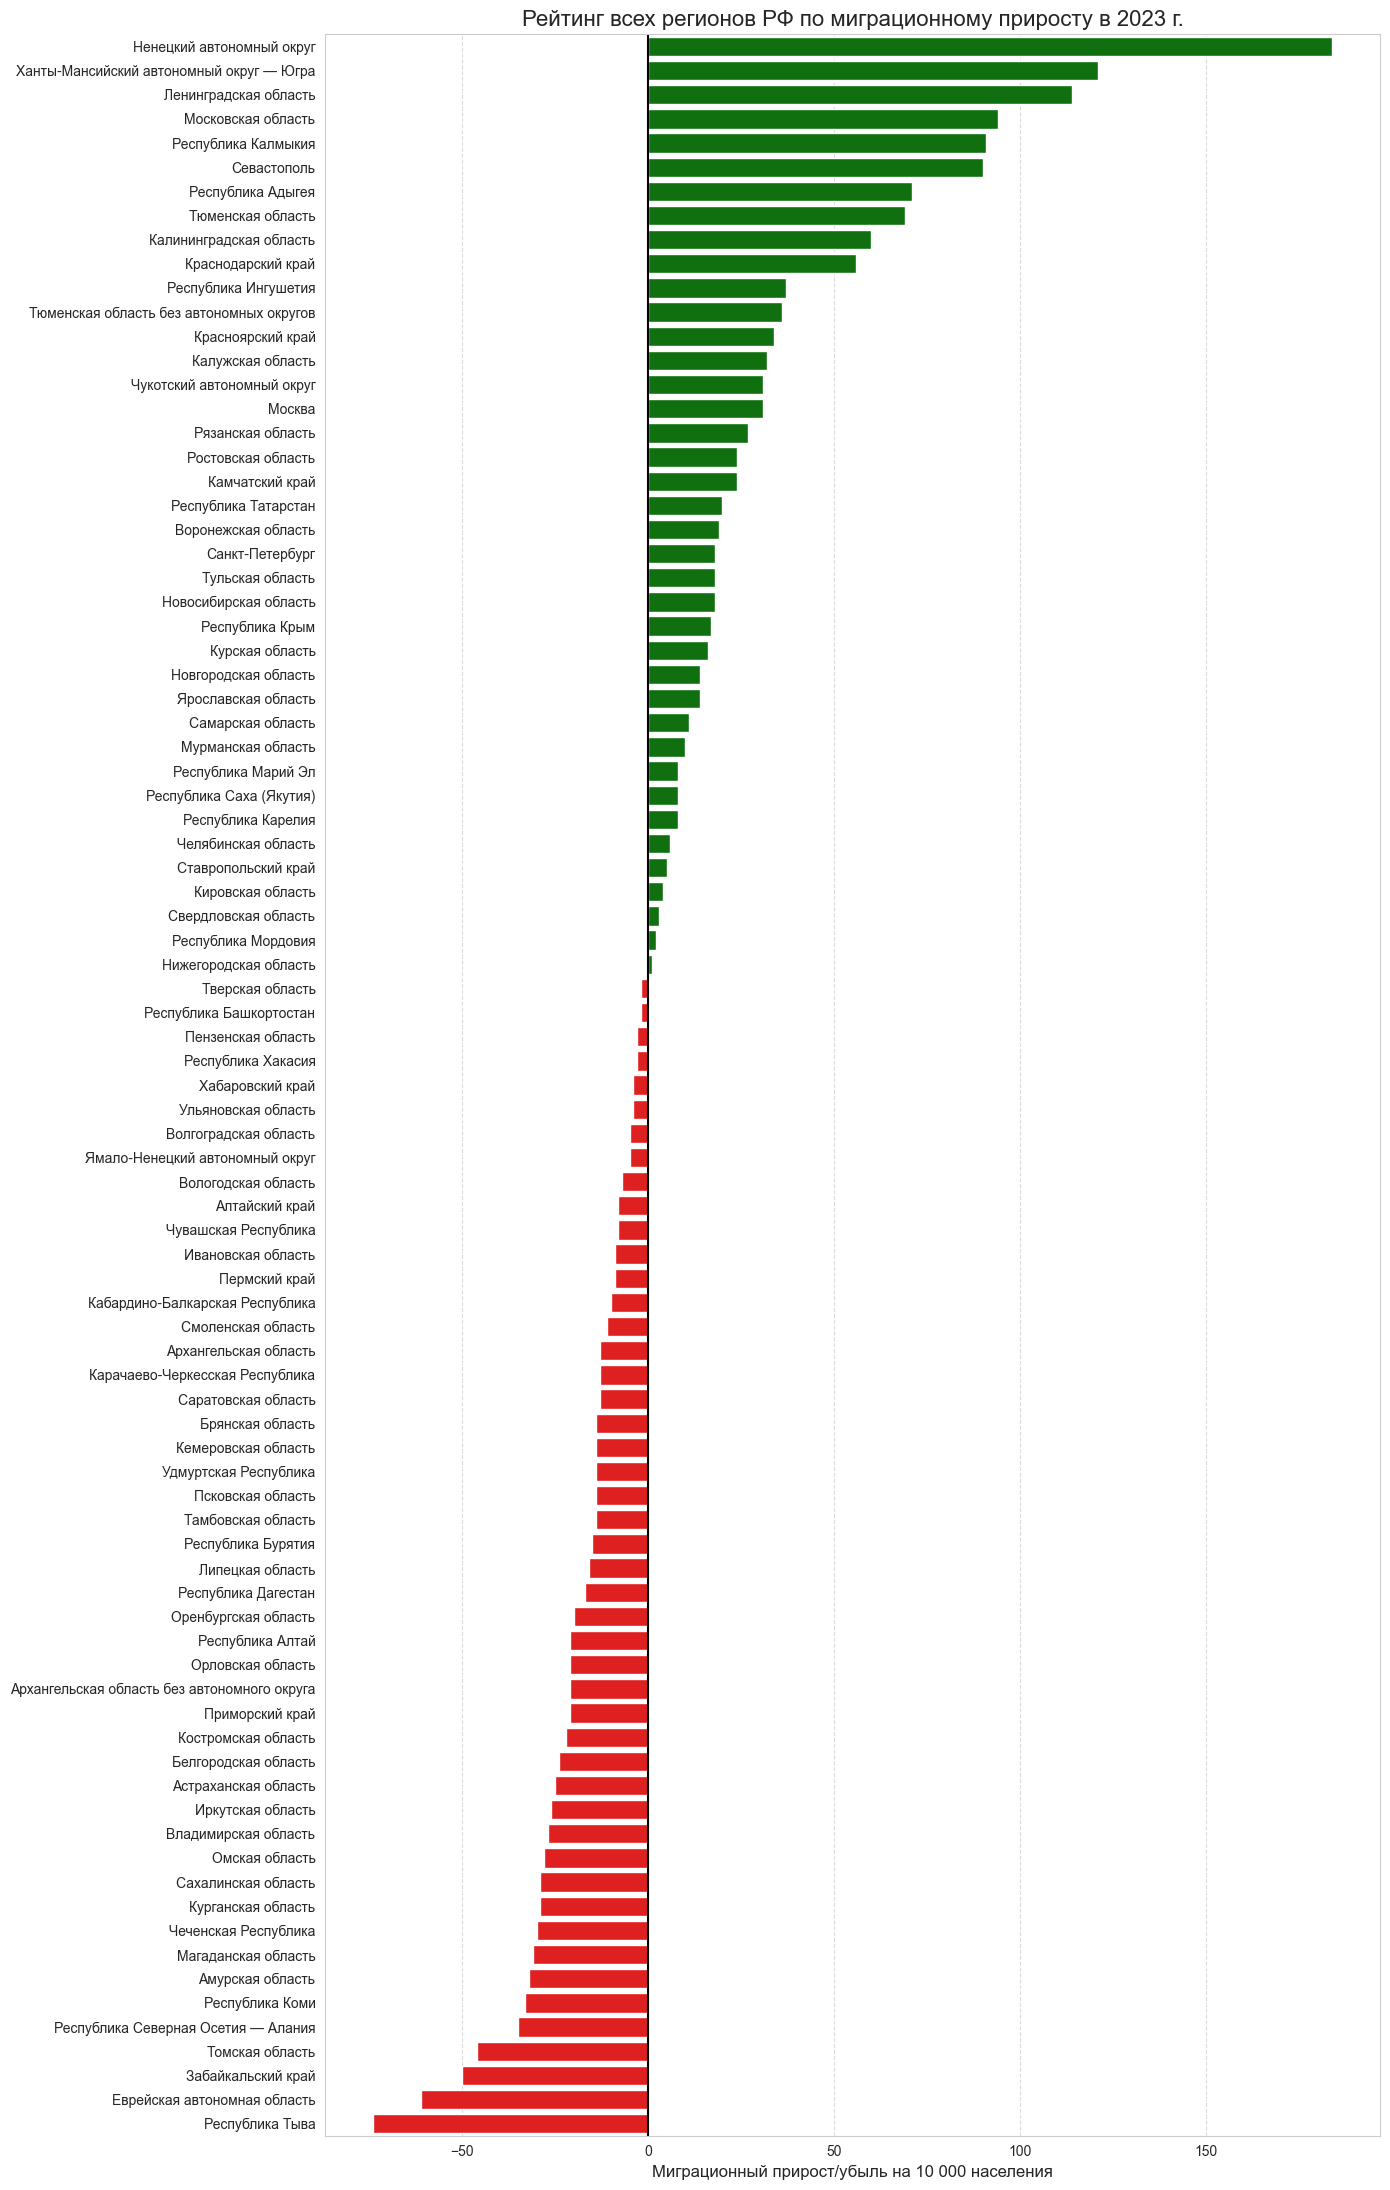

In [6]:
if 'migration_df' in locals():
    # Находим последний доступный год
    last_year = migration_df['year'].max()
    print(f"--- Полный рейтинг всех регионов по миграционному приросту за {last_year} год ---")

    # 1. ПОДГОТОВКА ДАННЫХ
    # Отбираем данные за последний год, удаляем пропуски и сортируем
    all_regions_migration = migration_df[migration_df['year'] == last_year].dropna().sort_values('migration_rate_per_10k', ascending=False)

    # 2. СОЗДАНИЕ ЦВЕТОВ
    # Создаем список цветов: 'g' (green) для положительных, 'r' (red) для отрицательных
    colors = ['g' if x > 0 else 'r' for x in all_regions_migration['migration_rate_per_10k']]

    # 3. ПОСТРОЕНИЕ ГРАФИКА
    # Создаем большую фигуру, чтобы все регионы поместились
    plt.figure(figsize=(14, 22))

    # Строим горизонтальный bar plot, используя наши цвета
    barplot = sns.barplot(
        data=all_regions_migration,
        x='migration_rate_per_10k',
        y='object_name',
        palette=colors # Применяем наш список цветов
    )

    # --- Улучшение читаемости графика ---
    plt.title(f'Рейтинг всех регионов РФ по миграционному приросту в {last_year} г.', fontsize=16)
    plt.xlabel('Миграционный прирост/убыль на 10 000 населения', fontsize=12)
    plt.ylabel('') # Убираем подпись оси Y
    plt.grid(axis='x', linestyle='--', alpha=0.7) # Добавляем сетку для удобства

    # Добавляем вертикальную линию на нуле, чтобы четко видеть границу притока/оттока
    plt.axvline(x=0, color='black', linewidth=1.5)

    # Устанавливаем размер шрифта для названий регионов
    plt.yticks(fontsize=10)

    plt.tight_layout()
    plt.show()

else:
    print("❌ DataFrame 'migration_df' не найден. Запустите ячейку, где вы загружаете эти данные.")

--- Анализируем связь миграции и доходов за 2023 год ---
✅ Данные объединены. Найдено 87 регионов с полными данными.

Запускаем автоматическое размещение подписей (может занять несколько секунд)...
✅ Подписи размещены.


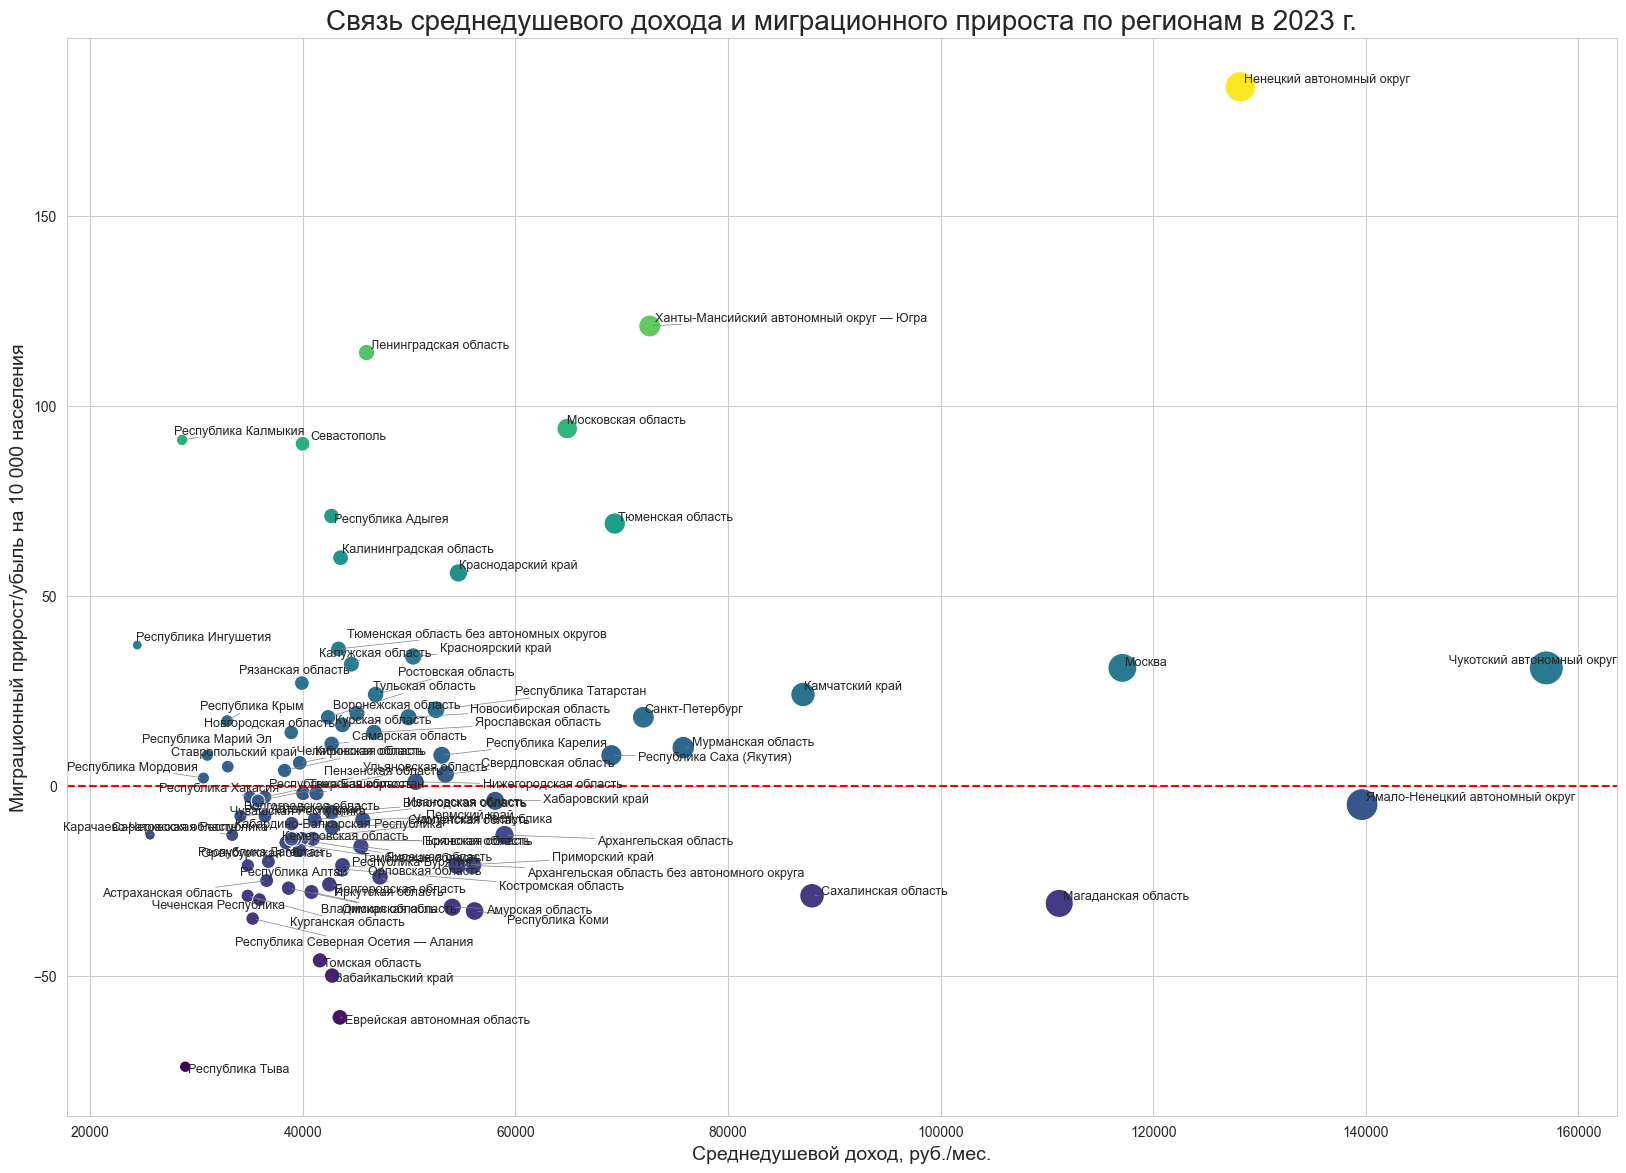

In [7]:
try:
    from adjustText import adjust_text
except ImportError:
    print("Библиотека adjustText не найдена. Установите ее: pip install adjustText")
    adjust_text = None

if 'wide_df' in locals() and 'migration_df' in locals():

    # --- 1. ОБЪЕДИНЕНИЕ ДАННЫХ (без изменений) ---
    last_year = min(wide_df['year'].max(), migration_df['year'].max())
    print(f"--- Анализируем связь миграции и доходов за {last_year} год ---")

    income_data = wide_df[wide_df['year'] == last_year][['region', 'avg_income']]
    migration_data = migration_df[migration_df['year'] == last_year].rename(columns={'object_name': 'region'})
    merged_df = pd.merge(income_data, migration_data, on='region', how='inner').dropna()

    print(f"✅ Данные объединены. Найдено {len(merged_df)} регионов с полными данными.")

    # --- 2. ВИЗУАЛИЗАЦИЯ С ПОДПИСЯМИ ВСЕХ ТОЧЕК ---

    plt.figure(figsize=(20, 14)) # Делаем график еще больше

    # Рисуем scatter plot, как и раньше
    scatter_plot = sns.scatterplot(
        data=merged_df,
        x='avg_income',
        y='migration_rate_per_10k',
        hue='migration_rate_per_10k',
        size='avg_income',
        sizes=(50, 600), # Увеличим максимальный размер
        palette='viridis',
        legend=False
    )

    plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)

    plt.title(f'Связь среднедушевого дохода и миграционного прироста по регионам в {last_year} г.', fontsize=20)
    plt.xlabel('Среднедушевой доход, руб./мес.', fontsize=14)
    plt.ylabel('Миграционный прирост/убыль на 10 000 населения', fontsize=14)

    # --- 3. ДОБАВЛЕНИЕ ПОДПИСЕЙ ---

    # Создаем список текстовых объектов для adjustText
    texts = []
    for _, row in merged_df.iterrows():
        texts.append(plt.text(row['avg_income'], row['migration_rate_per_10k'], row['region'], fontsize=9))

    # Запускаем "расталкивание" меток, если библиотека установлена
    if adjust_text:
        print("\nЗапускаем автоматическое размещение подписей (может занять несколько секунд)...")
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
        print("✅ Подписи размещены.")

    plt.grid(True)
    plt.show()

else:
    print("❌ Необходимые DataFrame 'wide_df' или 'migration_df' не найдены.")

In [8]:
## Убедимся, что у нас есть 'engine' для подключения к БД
if 'engine' in locals():
    try:
        # --- ШАГ 1: ВЫГРУЖАЕМ ВСЕ УНИКАЛЬНЫЕ НАЗВАНИЯ БЕЗ КИРИЛЛИЦЫ В ЗАПРОСЕ ---
        print("--- Шаг 1: Получаем все уникальные названия показателей из БД ---")

        # Этот SQL-запрос не содержит кириллицы и должен выполниться без ошибок
        sql_query_all_names = "SELECT DISTINCT indicator_name FROM rosstat_data;"
        all_indicators_df = pd.read_sql(sql_query_all_names, engine)
        all_indicators = all_indicators_df['indicator_name'].tolist()
        print(f"✅ Успешно получено {len(all_indicators)} уникальных названий.")

        # --- ШАГ 2: ИЩЕМ НУЖНЫЕ НАЗВАНИЯ УЖЕ ВНУТРИ PANDAS ---
        print("\n--- Шаг 2: Ищем нужные показатели в списке ---")

        # Ищем точное название для рождаемости
        birth_rate_name = [name for name in all_indicators if 'общие коэффициенты рождаемости' in name.lower()]
        # Ищем точное название для смертности
        death_rate_name = [name for name in all_indicators if 'общие коэффициенты смертности' in name.lower()]

        # Проверяем, что мы нашли оба показателя
        if not birth_rate_name or not death_rate_name:
            raise ValueError("Не удалось найти показатели рождаемости и/или смертности. Проверьте ключевые слова.")

        # Берем первое найденное (оно должно быть единственным)
        BIRTH_RATE_NAME = birth_rate_name[0]
        DEATH_RATE_NAME = death_rate_name[0]
        print(f"Найдено название для рождаемости: '{BIRTH_RATE_NAME}'")
        print(f"Найдено название для смертности: '{DEATH_RATE_NAME}'")

        # --- ШАГ 3: ВЫПОЛНЯЕМ ФИНАЛЬНЫЙ ЗАПРОС С ТОЧНЫМИ НАЗВАНИЯМИ ---
        print("\n--- Шаг 3: Загружаем данные по найденным показателям ---")

        # Теперь наш SQL-запрос снова чистый, без ILIKE и кириллицы
        sql_query_natural_growth = f"""
        SELECT
            object_name, year, indicator_name, indicator_value
        FROM
            rosstat_data
        WHERE
            indicator_name IN ('{BIRTH_RATE_NAME}', '{DEATH_RATE_NAME}')
            AND object_level = 'регион';
        """

        natural_growth_long_df = pd.read_sql(sql_query_natural_growth, engine)
        print(f"✅ Данные по рождаемости и смертности успешно загружены. Получено {len(natural_growth_long_df)} строк.")
        display(natural_growth_long_df.head())

    except Exception as e:
        print(f"❌ Произошла ошибка: {e}")
else:
    print("❌ Переменная 'engine' для подключения к БД не найдена.")

--- Шаг 1: Получаем все уникальные названия показателей из БД ---
✅ Успешно получено 823 уникальных названий.

--- Шаг 2: Ищем нужные показатели в списке ---
Найдено название для рождаемости: 'Общие коэффициенты рождаемости'
Найдено название для смертности: 'Общие коэффициенты смертности'

--- Шаг 3: Загружаем данные по найденным показателям ---
✅ Данные по рождаемости и смертности успешно загружены. Получено 4176 строк.


,object_name,year,indicator_name,indicator_value
0,Тверская область,2014,Общие коэффициенты рождаемости,11.3
1,Тверская область,2015,Общие коэффициенты рождаемости,11.3
2,Тверская область,2016,Общие коэффициенты рождаемости,11.2
3,Тверская область,2017,Общие коэффициенты рождаемости,9.9
4,Тверская область,2018,Общие коэффициенты рождаемости,9.1


In [9]:
if 'natural_growth_long_df' in locals():
    # --- 3. СЧИТАЕМ ЕСТЕСТВЕННЫЙ ПРИРОСТ ---

    # Трансформируем в "широкий" формат
    natural_growth_df = natural_growth_long_df.pivot_table(
        index=['object_name', 'year'],
        columns='indicator_name',
        values='indicator_value'
    ).reset_index()

    # Переименовываем колонки
    natural_growth_df = natural_growth_df.rename(columns={
        'object_name': 'region',
        BIRTH_RATE_NAME: 'birth_rate',
        DEATH_RATE_NAME: 'death_rate'
    })

    # Считаем естественный прирост (на 1000 человек, так как коэффициенты даны на 1000)
    natural_growth_df['natural_growth_rate'] = natural_growth_df['birth_rate'] - natural_growth_df['death_rate']

    print("✅ Рассчитан естественный прирост населения.")
    display(natural_growth_df.head())

    # --- 4. ОБЪЕДИНЯЕМ ВСЕ ДАННЫЕ ---
    # Возьмем данные за последний год из обеих таблиц

    last_year = migration_df['year'].max()
    migration_last_year = migration_df[migration_df['year'] == last_year].rename(columns={'object_name': 'region'})
    natural_growth_last_year = natural_growth_df[natural_growth_df['year'] == last_year]

    # Объединяем миграцию и естественный прирост
    total_growth_df = pd.merge(
        migration_last_year,
        natural_growth_last_year,
        on='region',
        how='inner' # Берем только те регионы, где есть оба показателя
    )

    # Считаем ОБЩИЙ прирост населения
    # ВАЖНО: миграция у нас на 10 000, а рождаемость/смертность на 1000. Приведем все к 1000.
    total_growth_df['migration_rate_per_1k'] = total_growth_df['migration_rate_per_10k'] / 10
    total_growth_df['total_growth_rate'] = total_growth_df['natural_growth_rate'] + total_growth_df['migration_rate_per_1k']

    print("\n✅ Все данные объединены и рассчитан общий прирост.")
    display(total_growth_df.head())

else:
    print("❌ DataFrame 'natural_growth_long_df' не найден. Запустите предыдущую ячейку.")

✅ Рассчитан естественный прирост населения.


indicator_name,region,year,birth_rate,death_rate,natural_growth_rate
0,Алтайский край,2000,9.3,14.3,-5.0
1,Алтайский край,2001,9.6,14.7,-5.1
2,Алтайский край,2002,10.3,15.7,-5.4
3,Алтайский край,2003,10.8,15.9,-5.1
4,Алтайский край,2004,10.9,15.9,-5.0



✅ Все данные объединены и рассчитан общий прирост.


,region,year_x,migration_rate_per_10k,year_y,birth_rate,death_rate,natural_growth_rate,migration_rate_per_1k,total_growth_rate
0,Белгородская область,2023,-24.0,2023,6.6,13.4,-6.8,-2.4,-9.2
1,Брянская область,2023,-14.0,2023,6.9,14.3,-7.4,-1.4,-8.8
2,Владимирская область,2023,-27.0,2023,6.4,15.5,-9.1,-2.7,-11.8
3,Воронежская область,2023,19.0,2023,7.2,14.3,-7.1,1.9,-5.2
4,Ивановская область,2023,-9.0,2023,7.2,16.1,-8.9,-0.9,-9.8


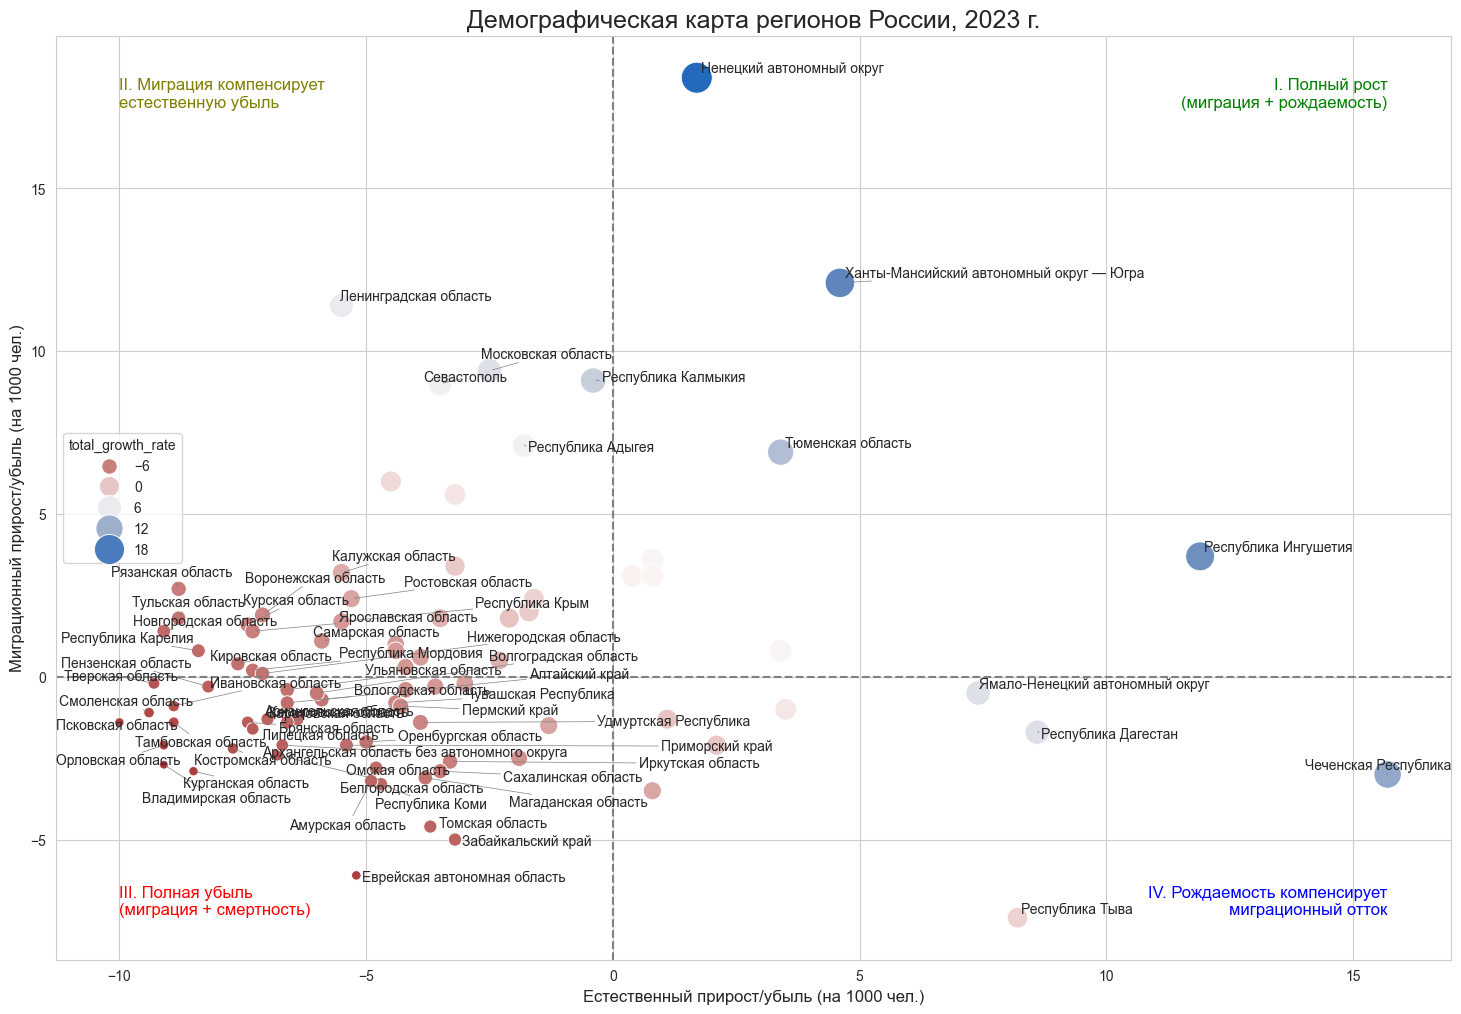

In [10]:
if 'total_growth_df' in locals():
    # --- 5. ВИЗУАЛИЗАЦИЯ: КВАДРАНТЫ ДЕМОГРАФИЧЕСКОГО РАЗВИТИЯ ---

    plt.figure(figsize=(18, 12))

    # Раскрасим точки в зависимости от ОБЩЕГО прироста
    palette = sns.color_palette("vlag_r", as_cmap=True)

    scatter = sns.scatterplot(
        data=total_growth_df,
        x='natural_growth_rate',
        y='migration_rate_per_1k',
        hue='total_growth_rate', # Цвет показывает общий результат
        size='total_growth_rate',
        sizes=(40, 500),
        palette=palette,
        legend=True
    )

    # Добавляем разделительные линии
    plt.axhline(0, color='grey', linestyle='--')
    plt.axvline(0, color='grey', linestyle='--')

    plt.title(f'Демографическая карта регионов России, {last_year} г.', fontsize=18)
    plt.xlabel('Естественный прирост/убыль (на 1000 чел.)', fontsize=12)
    plt.ylabel('Миграционный прирост/убыль (на 1000 чел.)', fontsize=12)

    # Добавляем подписи к квадрантам для понятности
    plt.text(total_growth_df.natural_growth_rate.max(), total_growth_df.migration_rate_per_1k.max(), 'I. Полный рост\n(миграция + рождаемость)', ha='right', va='top', fontsize=12, color='green')
    plt.text(total_growth_df.natural_growth_rate.min(), total_growth_df.migration_rate_per_1k.max(), 'II. Миграция компенсирует\nестественную убыль', ha='left', va='top', fontsize=12, color='olive')
    plt.text(total_growth_df.natural_growth_rate.min(), total_growth_df.migration_rate_per_1k.min(), 'III. Полная убыль\n(миграция + смертность)', ha='left', va='bottom', fontsize=12, color='red')
    plt.text(total_growth_df.natural_growth_rate.max(), total_growth_df.migration_rate_per_1k.min(), 'IV. Рождаемость компенсирует\nмиграционный отток', ha='right', va='bottom', fontsize=12, color='blue')

    # Подписываем самые интересные регионы
    texts = []
    for _, row in total_growth_df.iterrows():
        # Подпишем только регионы с сильными отклонениями
        if abs(row['total_growth_rate']) > 5 or abs(row['natural_growth_rate']) > 5:
             texts.append(plt.text(row['natural_growth_rate'], row['migration_rate_per_1k'], row['region']))

    if 'adjust_text' in locals():
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

    plt.grid(True)
    plt.show()

else:
    print("❌ DataFrame 'total_growth_df' не найден. Запустите предыдущую ячейку.")

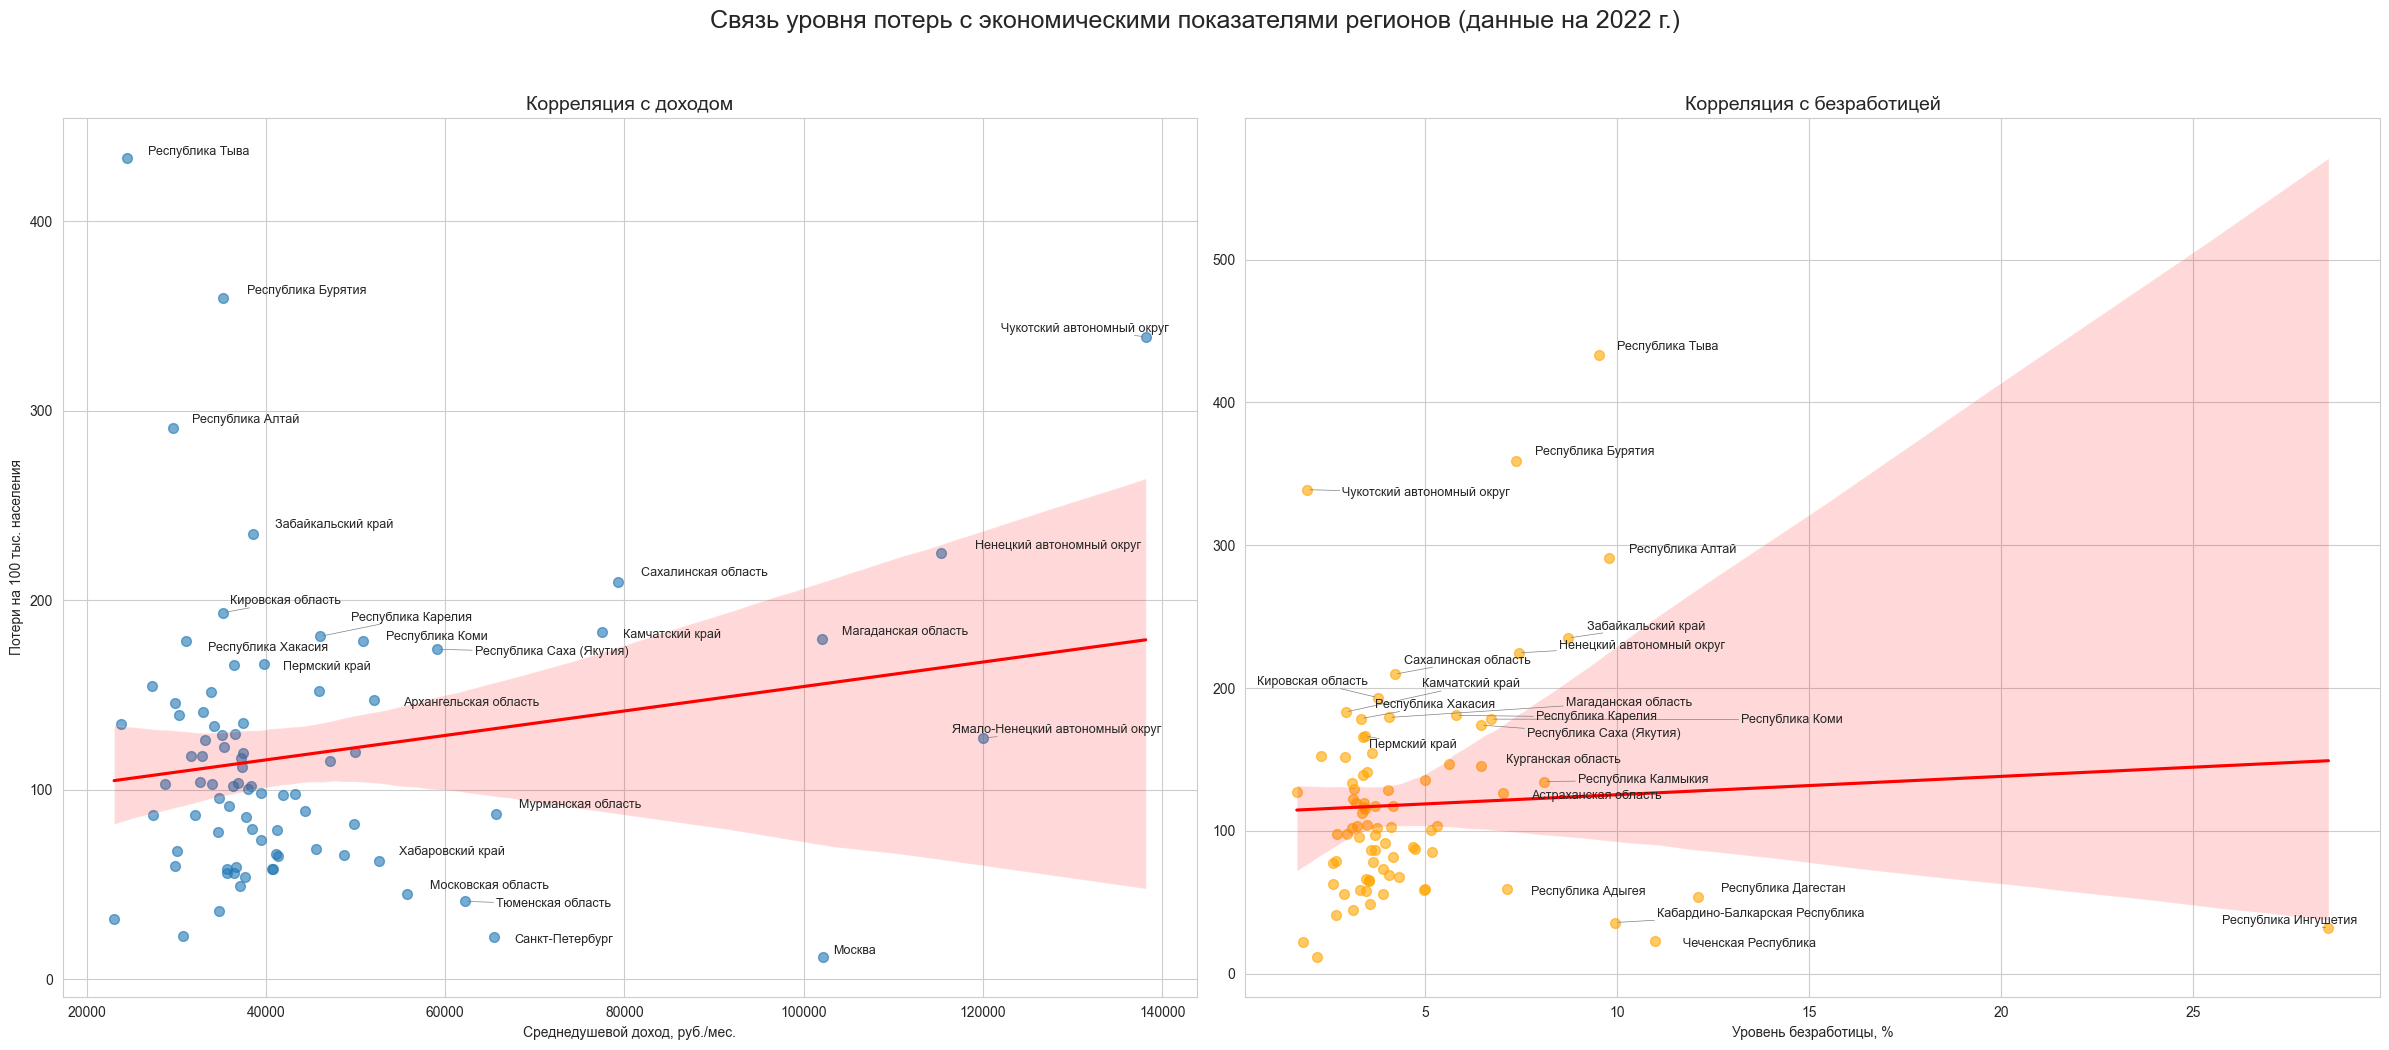

In [ ]:
try:
    from adjustText import adjust_text
except ImportError:
    print("Библиотека adjustText не найдена. Установите ее: pip install adjustText")
    adjust_text = None

if 'combined_df' in locals():
    # --- ВИЗУАЛИЗАЦИЯ С ПОДПИСЯМИ РЕГИОНОВ ---

    fig, axes = plt.subplots(1, 2, figsize=(24, 11)) # Сделаем холст еще шире
    fig.suptitle(f'Связь уровня потерь с экономическими показателями регионов (данные на {TARGET_YEAR} г.)', fontsize=18)

    # --- График 1: Доход vs. Потери ---
    sns.regplot(data=combined_df, x='avg_income', y='casualties_per_100k', ax=axes[0],
                scatter_kws={'alpha':0.6, 's': 50}, line_kws={'color':'red'})
    axes[0].set_title('Корреляция с доходом', fontsize=14)
    axes[0].set_xlabel('Среднедушевой доход, руб./мес.')
    axes[0].set_ylabel('Потери на 100 тыс. населения')
    axes[0].grid(True)

    # Добавляем подписи для выбросов на первом графике
    # (топ-15 по потерям и топ-15 по доходам)
    texts_income = []
    notable_income = pd.concat([
        combined_df.nlargest(15, 'casualties_per_100k'),
        combined_df.nlargest(15, 'avg_income')
    ]).drop_duplicates()

    for _, row in notable_income.iterrows():
        texts_income.append(axes[0].text(row['avg_income'], row['casualties_per_100k'], row['region'], fontsize=9))

    if adjust_text:
        adjust_text(texts_income, ax=axes[0], arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    # --- График 2: Безработица vs. Потери ---
    sns.regplot(data=combined_df, x='unemployment_rate_pct', y='casualties_per_100k', ax=axes[1],
                scatter_kws={'alpha':0.6, 'color': 'orange', 's': 50}, line_kws={'color':'red'})
    axes[1].set_title('Корреляция с безработицей', fontsize=14)
    axes[1].set_xlabel('Уровень безработицы, %')
    axes[1].set_ylabel('')
    axes[1].grid(True)

    # Добавляем подписи для выбросов на втором графике
    # (топ-15 по потерям и топ-15 по безработице)
    texts_unemployment = []
    notable_unemployment = pd.concat([
        combined_df.nlargest(15, 'casualties_per_100k'),
        combined_df.nlargest(15, 'unemployment_rate_pct')
    ]).drop_duplicates()

    for _, row in notable_unemployment.iterrows():
        texts_unemployment.append(axes[1].text(row['unemployment_rate_pct'], row['casualties_per_100k'], row['region'], fontsize=9))

    if adjust_text:
        adjust_text(texts_unemployment, ax=axes[1], arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

else:
    print("❌ DataFrame 'combined_df' не найден.")

In [12]:
if 'engine' in locals():
    # 1. Получаем список регионов из данных Росстата (наша "эталонная" таблица)
    rosstat_regions_df = pd.read_sql("SELECT DISTINCT object_name FROM rosstat_data WHERE object_level = 'регион'", engine)
    rosstat_regions = set(rosstat_regions_df['object_name']) # Превращаем в множество для быстрого поиска
    print(f"Найдено {len(rosstat_regions)} уникальных регионов в данных Росстата.")

    # 2. Получаем список регионов из нашей таблицы потерь
    casualties_regions_df = pd.read_sql("SELECT DISTINCT region FROM casualties_mediazona", engine)
    casualties_regions = set(casualties_regions_df['region'])
    print(f"Найдено {len(casualties_regions)} уникальных регионов в данных о потерях.")

    # 3. Находим несовпадения
    print("\n--- Регионы из таблицы потерь, которых НЕТ в данных Росстата: ---")
    unmatched_regions = casualties_regions - rosstat_regions # Вычитаем одно множество из другого

    if not unmatched_regions:
        print("✅ Отлично! Все регионы из таблицы потерь найдены в данных Росстата.")
    else:
        for region in sorted(list(unmatched_regions)):
            print(f"  - '{region}'")

    print("\n--- Для справки: несколько примеров названий из Росстата ---")
    print(sorted(list(rosstat_regions))[:10])

else:
    print("❌ 'engine' не найден.")

Найдено 87 уникальных регионов в данных Росстата.
Найдено 87 уникальных регионов в данных о потерях.

--- Регионы из таблицы потерь, которых НЕТ в данных Росстата: ---
  - 'Донецкая Народная Республика'
  - 'Кемеровская область - Кузбасс'
  - 'Луганская Народная Республика'
  - 'Республика Северная Осетия - Алания'
  - 'Ханты-Мансийский автономный округ - Югра'
  - 'г. Москва'
  - 'г. Санкт-Петербург'
  - 'г. Севастополь'

--- Для справки: несколько примеров названий из Росстата ---
['Алтайский край', 'Амурская область', 'Архангельская область', 'Архангельская область без автономного округа', 'Астраханская область', 'Белгородская область', 'Брянская область', 'Владимирская область', 'Волгоградская область', 'Вологодская область']


In [ ]:
if 'engine' in locals():
    print("--- Проводим ТЕСТОВЫЙ JOIN двух таблиц ---")

    TARGET_YEAR = 2023
    POPULATION_INDICATOR = 'Численность населения'

    # Упрощенный запрос, который соединяет только население и потери
    test_join_sql = f"""
    SELECT
        p.region,
        p.population,
        c.casualties_count
    FROM
        (
            SELECT object_name AS region, indicator_value AS population
            FROM rosstat_data
            WHERE year = {TARGET_YEAR} AND object_level = 'регион' AND indicator_name = '{POPULATION_INDICATOR}'
        ) AS p
    JOIN
        casualties_regions AS c ON p.region = c.region;
    """

    try:
        # Пытаемся выполнить этот простой JOIN
        test_join_df = pd.read_sql(test_join_sql, engine)

        print(f"\n✅ Тестовый JOIN выполнен. Найдено совпадений: {len(test_join_df)}")

        if len(test_join_df) > 0:
            print("Это значит, что проблема в данных по ЭКОНОМИКЕ (доходы/безработица).")
            display(test_join_df.head())
        else:
            print("❌ Проблема подтверждена: JOIN между Населением и Потерями не находит совпадений.")
            print("Это значит, что названия регионов все еще не совпадают, несмотря на исправления.")

    except Exception as e:
        print(f"❌ Произошла ошибка при выполнении тестового JOIN: {e}")

else:
    print("❌ 'engine' не найден.")

--- Проводим ТЕСТОВЫЙ JOIN двух таблиц ---

✅ Тестовый JOIN выполнен. Найдено совпадений: 82
Это значит, что проблема в данных по ЭКОНОМИКЕ (доходы/безработица).


,region,population,casualties_count
0,Белгородская область,1500.7,1475
1,Брянская область,1142.4,1375
2,Владимирская область,1309.9,1032
3,Москва,13149.8,1555
4,Воронежская область,2273.4,1515
